In [1]:
import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Model, Input
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, concatenate, SpatialDropout1D
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import classification_report
from nltk import word_tokenize

from model_utils import create_elmo_crf_model, save_model_weights, load_model_weights, get_embedding_layer


plt.style.use("ggplot")

Using TensorFlow backend.
W0513 15:48:28.938076 11236 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
data = pd.read_csv("Data/ner_data.tsv", encoding="latin-1", sep="\t")
load_model = True

grouped_data = dict(list(data.groupby("sentence_id")))
sentences = [g["word"].tolist() for k, g in grouped_data.items()]
sentence_tags = [g["tag"].tolist() for k, g in grouped_data.items()]

In [3]:
words = ["<PAD>"] + list(data["word"].unique())
tags = ["<PAD>"] + list(data["tag"].unique())
chars = set([w_i for w in words for w_i in w])

n_words = len(words)
n_tags = len(tags)
n_chars = len(chars)

print("-"*50)
print(f"Number of sentences: \t\t{len(sentences)}")
print(f"Number of unique words: \t{n_words}")
print(f"Number of unique tags: \t\t{n_tags}")
print(f"Number of unique chars: \t{n_chars}")
print("-"*50)

--------------------------------------------------
Number of sentences: 		48335
Number of unique words: 	34718
Number of unique tags: 		16
Number of unique chars: 	105
--------------------------------------------------


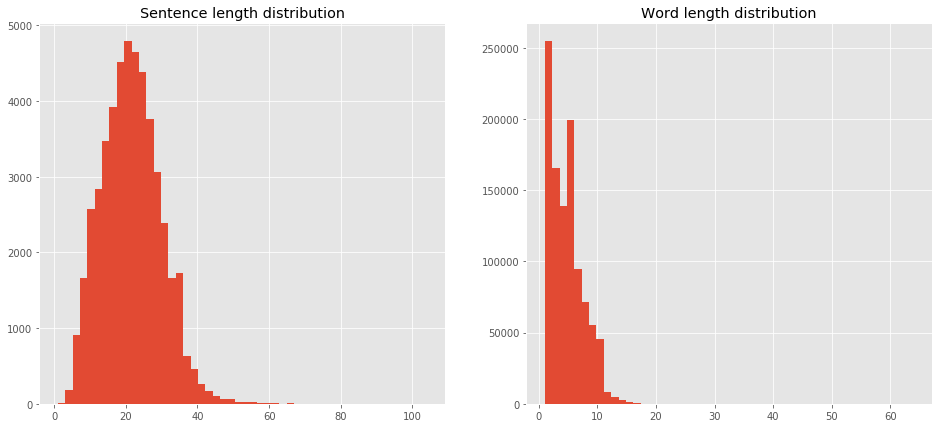

In [4]:
plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
plt.title("Sentence length distribution")
plt.hist([len(s) for s in sentences], bins=50)

plt.subplot(1, 2, 2)
plt.title("Word length distribution")
plt.hist([len(w) for s in sentences for w in s], bins=50)

plt.show()

In [5]:
max_len = 50
batch_size = 32

tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}

In [6]:
X = [[w for w in s] for s in sentences]
X = pad_sequences(X, maxlen=max_len, padding="post", dtype=object, value="<PAD>")
y = [[tag2idx[t] for t in s] for s in sentence_tags]
y = pad_sequences(y, maxlen=max_len, padding="post", dtype=object, value=tag2idx["<PAD>"])
y = [to_categorical(x, num_classes=n_tags) for x in y]

<h2>Here comes ELMo</h2>

![elmo.jpg](attachment:elmo.jpg)

In [7]:
model = create_elmo_crf_model(n_tags=n_tags, max_len=max_len, 
                              batch_size=32, compile_model=True, elmo_path="Models/elmo2")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 15:49:39.088664 11236 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 1024)     6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 1024)     6295552     bidirectional_1[0][0]            
__________________________________________________________________________________________________
add_1 (Add

In [9]:
plot_model(model, show_shapes=True, to_file="model.png")

![model.png](attachment:model.png)

![conv.png](attachment:conv.png)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

n_batches = len(X_train) // batch_size
n_train_batches = int(0.99 * n_batches)
n_val_batches = int(n_batches - n_train_batches)

X_train, X_val = X_train[:n_train_batches*batch_size], X_train[-n_val_batches*batch_size:]
y_train, y_val = y_train[:n_train_batches*batch_size], y_train[-n_val_batches*batch_size:]

In [11]:
load_model = False

if load_model:
    load_model_weights(model, "Models/ner_e2.h5")
else:
    training = model.fit(np.array(X_train), np.array(y_train), 
                         validation_data=(np.array(X_val), np.array(y_val)), 
                         batch_size=batch_size, epochs=2, verbose=1)
    save_model_weights(model, "Models/ner_e2.h5")

Train on 43040 samples, validate on 448 samples
Epoch 1/2
43040/43040 [==============================] - 1520s 35ms/step - loss: 0.0517 - val_loss: 0.0232
Epoch 2/2
43040/43040 [==============================] - 1529s 36ms/step - loss: 0.0046 - val_loss: -0.0087


In [12]:
X_test = X_test.tolist()
# y_test = y_test.tolist()

if len(X_test) % batch_size != 0:
    m = len(X_test) % batch_size
    for i in range(0, batch_size - m):
        X_test.append(["<PAD>"]*max_len)
        y_test.append([tag2idx["<PAD>"]]*max_len)

In [13]:
n_batches = len(X_test) // batch_size

y_true, y_pred = [], []

for n in range(n_batches):
    x_batch = X_test[n:n+batch_size]
    y_batch = y_test[n:n+batch_size]
    
    predictions = model.predict(np.array(x_batch))
    
    for i, prediction in enumerate(predictions):
        p = np.argmax(prediction, axis=-1)
        for w, pred, true in zip(x_batch[i], p, y_batch[i]):
            y_true.append(np.argmax(true))
            y_pred.append(pred)

In [20]:
x_t = [["<PAD>"] * max_len] * batch_size

sentence = "He has been working as a software developer since January 2018"

# sentence = "red apple lies on the table"
# sentence = "Apple is a great company"
# sentence = "Have you been to Big Apple?"
tokens = word_tokenize(sentence)

for i, token in enumerate(tokens):
    x_t[0][i] = token
    
p = model.predict(np.array(x_t))[0]
p = np.argmax(p, axis=-1)

print("{:15} {:5}".format("Word", "Pred"))
print("-"*30)

for w, pred in zip(x_t[0], p):
    if w != "<PAD>":
        print("{:15}:{:5}".format(w, idx2tag[pred]))

Word            Pred 
------------------------------
He             :O    
has            :O    
been           :O    
working        :O    
as             :O    
a              :O    
software       :B-pos
developer      :I-pos
since          :B-tim
January        :I-tim
2018           :I-tim
